# Transmission Matrix

Samples:  49 6 7
Batch:  2 1 1
Batch shapes: torch.Size([7, 256, 256]), torch.Size([7, 32, 32])


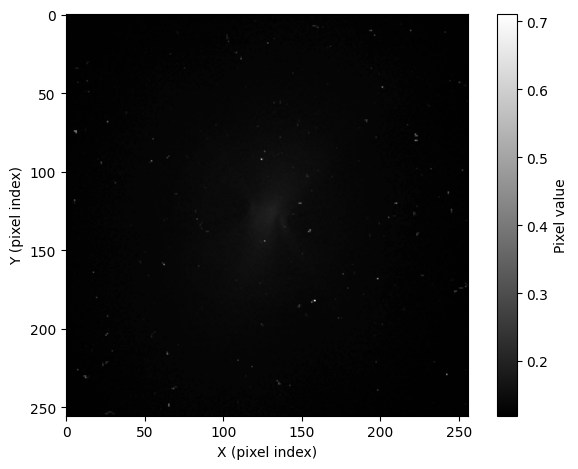

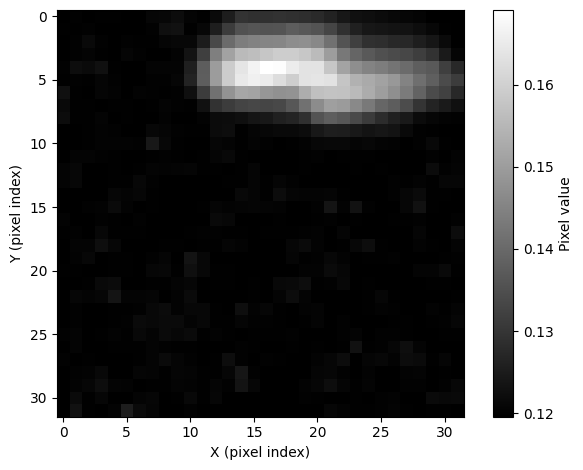

Detected framework: PyTorch
Framework:           PyTorch
Model:               TransmissionMatrix
Device / dtype:      unavailable / N/A
Parameters:          67,108,864 total
                     67,108,864 trainable
                     0 non-trainable
Size:                256.00 MB
Sub-modules:         2


In [1]:
# pip install xflow-py
from xflow import ConfigManager, FileProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.trainers import build_callbacks_from_config, build_callbacks_from_config
from xflow.utils import load_validated_config, plot_image

from TM import TransmissionMatrix
from config_utils import load_config

# Configuration
# config_manager = ConfigManager(load_validated_config("TM.yaml"))
config_manager = ConfigManager(load_config("TM.yaml"))
config = config_manager.get()
config_manager.add_files(config["extra_files"])

# Data pipeline
provider = FileProvider(config["paths"]["dataset"]).subsample(fraction=0.01, seed=config["seed"])
train_provider, temp_provider = provider.split(ratio=config["data"]["train_val_split"], 
                                               seed=config["seed"])
val_provider, test_provider = temp_provider.split(ratio=config["data"]["val_test_split"], 
                                                  seed=config["seed"])
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])

def make_dataset(provider):
    return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

train_dataset = make_dataset(train_provider)
val_dataset = make_dataset(val_provider)
test_dataset = make_dataset(test_provider)

print("Samples: ",len(train_provider),len(val_provider),len(test_provider))
print("Batch: ",len(train_dataset),len(val_dataset),len(test_dataset))

for left_parts, right_parts in test_dataset:
    # batch will be a tuple: (right_halves, left_halves) due to split_width
    print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
    plot_image(left_parts[0])
    plot_image(right_parts[0])
    break

# Model
model = TransmissionMatrix(
    input_height = config["data"]["input_image_size"][0],
    input_width = config["data"]["input_image_size"][1],
    output_height = config["data"]["output_size"][0],
    output_width = config["data"]["output_size"][1],
    initialization = "xavier"
)

show_model_info(model)

In [ ]:
import torch
import torch.nn.functional as F
import xflow.extensions.physics

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = torch.nn.MSELoss()  # pixel level MSE
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])

# Callbacks
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],
)
callbacks[-1].set_dataset(test_dataset)  # add dataset closure to the last callback

train_losses, val_losses = [], []

# Training loop
for cb in callbacks:
    cb.on_train_begin(epochs=config['training']['epochs'])  # Pass total epochs

for epoch in range(config['training']['epochs']):
    for cb in callbacks:
        cb.on_epoch_begin(epoch, model=model, total_batches=len(train_dataset))

    model.train()
    train_loss_sum, n_train = 0.0, 0
    
    for batch_idx, batch in enumerate(train_dataset):
        for cb in callbacks: 
            cb.on_batch_begin(batch_idx)

        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()                      # 1. clear gradients
        outputs = model(inputs)                    # 2. forward pass
        loss = criterion(outputs, targets)         # 3. compute loss
        loss.backward()                            # 4. backprop
        optimizer.step()                           # 5. update weights

        # Convert tensor to float for logging
        for cb in callbacks:
            cb.on_batch_end(batch_idx, logs={"loss": loss.item()})

        # accumulate for epoch average
        train_loss_sum += loss.item()
        n_train += 1

    avg_train_loss = train_loss_sum / max(1, n_train)

    # ----- validation pass (no grad) -----
    model.eval()
    val_loss_sum, n_val = 0.0, 0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataset:     
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss_sum += criterion(val_outputs, val_targets).item()
            n_val += 1
    avg_val_loss = val_loss_sum / max(1, n_val)

    # Save losses to history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Add epoch-level metrics if available
    for cb in callbacks:
        cb.on_epoch_end(epoch, logs={
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        })
        
    # Check for early stopping after all callbacks have run
    if any(getattr(cb, 'should_stop', False) for cb in callbacks):
        print("Early stopping triggered - training stopped.")
        break

# Call once after training
for cb in callbacks:
    cb.on_train_end()

# Save training history (simplest approach)
import json
with open(f"{config['paths']['output']}/history.json", 'w') as f:
    json.dump({'train_loss': train_losses, 'val_loss': val_losses}, f)
    
# Save final trained model for inference
model.save_model(config["paths"]["output"])
config_manager.save(output_dir=config["paths"]["output"])

In [2]:
import torch
from xflow.trainers import TorchTrainer, build_callbacks_from_config
import xflow.extensions.physics

# 1) device/model/optim/loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])

# 2) callbacks (unchanged) + any custom wiring
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],   # e.g. "torch"
)
callbacks[-1].set_dataset(test_dataset)  # keep your dataset closure if needed

# 3) run training
trainer = TorchTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    callbacks=callbacks,
    output_dir=config["paths"]["output"],
    data_pipeline=train_dataset
)

history = trainer.fit(
    train_loader=train_dataset,   # your DataLoader/Iterable
    val_loader=val_dataset,
    epochs=config['training']['epochs'],
)

# 4) persist
trainer.save_history(f"{config['paths']['output']}/history.json")
trainer.save_model(config["paths"]["output"])  # uses model.save_model(...) if available
config_manager.save(output_dir=config["paths"]["output"])


Starting Training

Epoch 1 - 2 batches
input image max pixel: 0.6315, ground truth image max pixel: 0.7560, reconstructed image max pixel: 0.6167
[==============================] 2/2 (100.0%) - ETA: 0s - train_loss: 0.0607 - val_loss: 0.0195    
Epoch 1 completed in 5.39s - train_loss: 0.0607 - val_loss: 0.0195

Epoch 2 - 2 batches
input image max pixel: 0.5786, ground truth image max pixel: 0.1342, reconstructed image max pixel: 0.4461
[==============================] 2/2 (100.0%) - ETA: 0s - train_loss: 0.0158 - val_loss: 0.0102    
Epoch 2 completed in 6.05s - train_loss: 0.0158 - val_loss: 0.0102

Epoch 3 - 2 batches
input image max pixel: 0.6777, ground truth image max pixel: 0.6036, reconstructed image max pixel: 0.3784
[==============================] 2/2 (100.0%) - ETA: 0s - train_loss: 0.0112 - val_loss: 0.0113    
Epoch 3 completed in 7.69s - train_loss: 0.0112 - val_loss: 0.0113

Epoch 4 - 2 batches
input image max pixel: 0.7109, ground truth image max pixel: 0.1691, reconst

# Inference

In [ ]:
import torch
from xflow.extensions.physics.beam import extract_beam_parameters

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransmissionMatrix.load_model('../TM_03/model.pth', device=device)
model.eval()  # Set to evaluation mode

# Clean PyTorch inference - just use forward pass
print("Testing inference...")
with torch.no_grad():
    for batch in test_dataset:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        print(f"Input shape: {inputs.shape}")
        print(f"Target shape: {targets.shape}")
        
        # Pure PyTorch way - same as training!
        reconstructed_images = model(inputs)
        print(f"Reconstructed shape: {reconstructed_images.shape}")
        
        # Plot first sample
        plot_image(inputs[0], title="Input")
        plot_image(reconstructed_images[0], title="Reconstructed") 
        plot_image(targets[0], title="Ground Truth")
        
        # Only process first batch for testing
        break